In [16]:
data_directory ="IV_meas/G2_Endurance/"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re #allows string splitting and searching, used to find the voltage for labelling graphs
import matplotlib
from matplotlib.pyplot import figure

In [3]:
SMALLER_SIZE = 12
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [18]:
filepaths = [f for f in glob.glob(data_directory + "**")]
print(len(filepaths))

72


In [19]:
def dataCollection(file):
    indexnames = pd.read_csv(file, header = None, usecols = [0])
    skiplist = []
    c = 0
    for item in indexnames.values[:]:
        if item != "DataValue":
            skiplist.append(c)
        c += 1
    treated_data = pd.read_csv(file, skiprows = skiplist, index_col = 0)
    time = treated_data.values[:499,0].astype(float)
    curr = treated_data.values[:499,1].astype(float)
    pot = treated_data.values[:499,2].astype(float)
    return(time, pot, curr)

In [20]:
"""Remanent polarization and Polarization list"""
def PV_char(time, curr, pot): #time is in seconds, current is in amperes, potential is in volts
    time = time*1000 #time in ms now
    curr = -curr*1e6 #current in uA now
    i=0
    Q = []; q = 0
    for j in range(len(time)):
        q += curr[j]-curr[0]
        Q.append(q)
    Q = np.array(Q)*(time[1]-time[0])/1e3 #in uC
    d = 15e-09 #m
    r = 25e-04 #cm
    A = np.pi*r**2 #cm2
    P = np.array(Q).astype(float)/A #uC/cm2
    P1 = [P[0:50]]; P2 = P[100:150]
    pr = (P1[-1]-P2[-1])/2
    return(P)

In [21]:
def prFromP(P):
    start = 200; end = 400 #two points which should have the same value
    CAC = (P[end]-P[start])/(time[end]-time[start])
    current_asymmetry = time*CAC
    P = P-current_asymmetry-(P[200]-current_asymmetry[200])
    pr = (P[300]-P[200])/2
    P = P-pr
    return(pr)

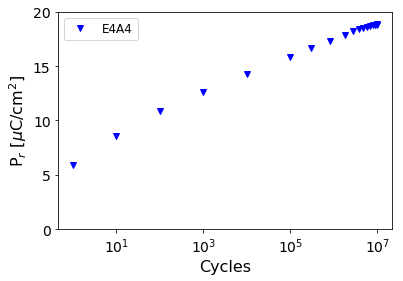

In [32]:
"""Single Sample Endurance for the sample with 10 M cycles."""
tenM_sample = ["E4A4"]
for i in range(len(tenM_sample)):
    sample = tenM_sample[i]
    cycles_array = []
    pr_array = []
    for file in filepaths:
        if sample in file: #Filters out the correct datafile
            time, pot, curr = dataCollection(file)
            if re.search("After (.*)Cycles", file) == None:
                cycles = 1
            else:
                cycles = float(re.search("After (.*)Cycles", file).group(1).replace(" ", "")) #find the number of cycles...
            cycles_array.append(cycles)
            P = PV_char(time, curr, pot)
            pr = prFromP(P)
            pr_array.append(pr)
    cycles_array = np.array(cycles_array)
    pr_array = np.array(pr_array)
    data = np.array([cycles_array, pr_array])
    data = np.array(sorted(data.T, key=lambda x: x[0], reverse=False))
    plt.plot(data[:,0],data[:,1], style[i], label = sample)
    plt.xscale('log')
plt.legend()
plt.xlabel('Cycles')
plt.ylabel('P$_r$ [$\mu$C/cm$^2$]')
plt.ylim(0,20)
# plt.savefig(homedir + '/IV_meas/PrResults/Endurance_10M.png')
plt.show()

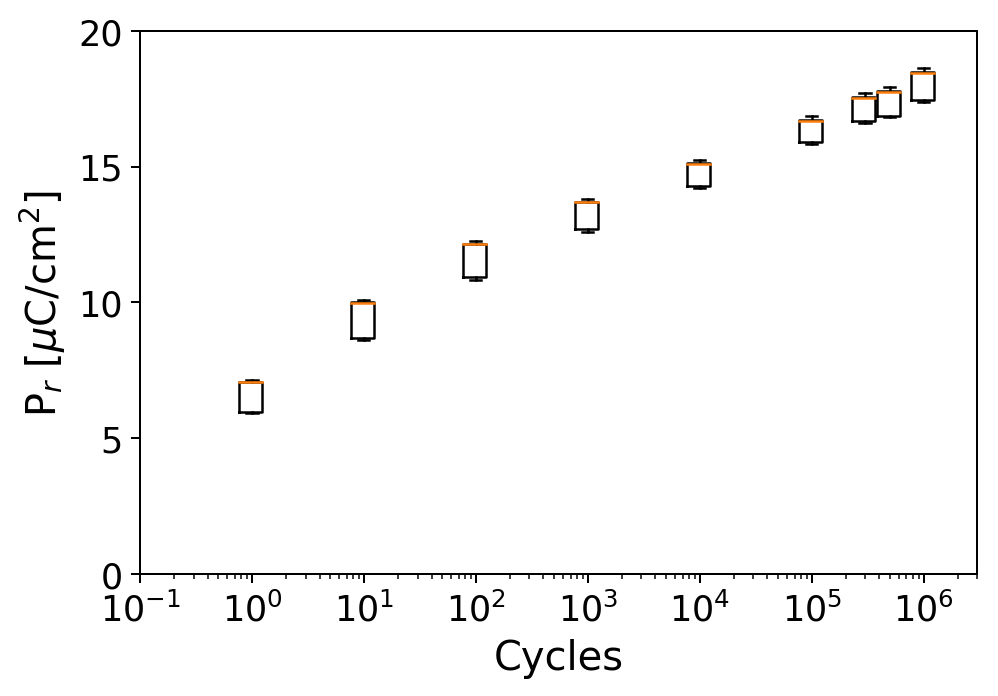

In [33]:
"""Box Plot Statistics for the 6 devices measured to 1 M cycles"""
oneM_samples = ["E4A5","E4A6","A7A1","A7A2","A7A3"]
style = ["bv", "r*", "go", "ks", "m^"]
pr_array = []
figure(dpi=180)
for i in range(len(oneM_samples)):
    sample = oneM_samples[i]
    cycles_array = []
    temp_pr = []
    for file in filepaths:
        if sample in file:
            time, pot, curr = dataCollection(file)
            if re.search("After (.*)Cycles", file) == None:
                cycles = 1
            else:
                cycles = float(re.search("After (.*)Cycles", file).group(1).replace(" ", "")) #find the number of cycles...
            cycles_array.append(cycles)
            P = PV_char(time, curr, pot)
            pr = prFromP(P)
            temp_pr.append(pr)
    temp_pr = [x for _,x in sorted(zip(cycles_array,temp_pr))]
    pr_array.append(temp_pr)
    cycles_array = np.array(cycles_array)
    cycles_array = sorted(cycles_array)
pr_array = np.array(pr_array)
w = 0.2
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
plt.boxplot(pr_array, positions = cycles_array, widths=width(cycles_array,w))
# plt.plot(cycles_array, pr_array.T)
# plt.xticks([1,2,3,4,5,6,7,8,9], cycles_array)
plt.xscale('log')
plt.xlim(1e-1,3e6)
plt.xlabel('Cycles')
plt.ylabel('P$_r$ [$\mu$C/cm$^2$]')
plt.ylim(0,20)
# plt.savefig(homedir + '/IV_meas/PrResults/Endurance_1M_boxplot_statistics.png')
plt.show()

1.0
10.0
100.0
1000.0
10000.0
100000.0
300000.0
800000.0
1800000.0
2800000.0
3800000.0
4800000.0
5800000.0
6800000.0
7800000.0
8800000.0
9800000.0
10000000.0


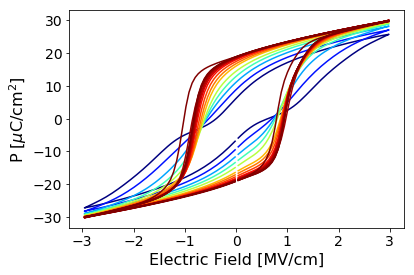

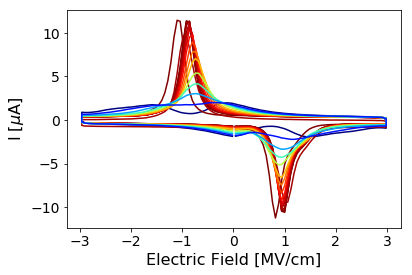

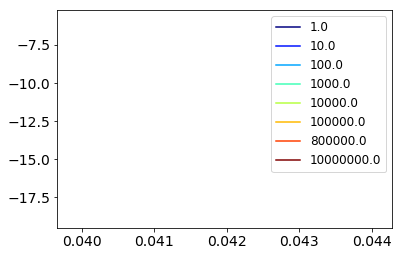

In [86]:
"""Single Sample Hysteresis Loop"""
tenM_sample = ["E4A4"]
start = 200; end = start + 200
Rainbow = plt.get_cmap('jet')
for i in range(len(tenM_sample)):
    sample = tenM_sample[i]
    cycles_array = []
    Parray = []
    Carray = []
    for file in filepaths:
        if sample in file:
            time, pot, curr = dataCollection(file)
            if re.search("After (.*)Cycles", file) == None:
                cycles = 1
            else:
                cycles = float(re.search("After (.*)Cycles", file).group(1).replace(" ", "")) #find the number of cycles...
            cycles_array.append(cycles)
            P = PV_char(time, curr, pot)
            pr = prFromP(P)
            glue = (P[end]-P[start])/(time[end]-time[start]) #The difference between the start and end points
            glue_factor = time*glue #A linear slope from 0 to the difference.
            P = P-glue_factor-(P[start]-glue_factor[start]) #this is subtracted in order to "glue" the first and last data points
            P = P-pr
            Parray.append(P[start:end])
            Carray.append(curr[start:end])
    cycles_array = np.array(cycles_array)
    data = np.array([cycles_array, Parray])
    data2 = np.array([cycles_array, Carray])
    data = np.array(sorted(data.T, key=lambda x: x[0], reverse=False)).T
    data2 = np.array(sorted(data2.T, key=lambda x: x[0], reverse=False)).T
fig1, ax1 = plt.subplots(dpi = 72) #PE curve
fig2, ax2 = plt.subplots(dpi = 72) #IV curve
fig3, ax3 = plt.subplots(dpi = 72) #legend

for i in range(len(cycles_array)):
    print(data[0,i])
    cmap_color = np.log(data[0,i])/np.log(10000000)
    cmap_color_rev = np.log(data[0,-i])/np.log(10000000)
    if data[0,i] in [1,10,100,1000,10000,100000,800000,10000000]:
        ax1.plot(pot[start:end]/(1e6*15e-7), data[1,i], label = data[0,i], color = Rainbow(cmap_color))
        ax2.plot(pot[start:end]/(1e6*15e-7), data2[1,-i]*1e6, label = data[0,-i], color = Rainbow(cmap_color_rev))
        ax3.plot(pot[0]/(1e6*15e-7), data[1,i][0], label = data[0,i], color = Rainbow(cmap_color))
    else:
        ax1.plot(pot[start:end]/(1e6*15e-7), data[1,i], color = Rainbow(cmap_color))
        ax2.plot(pot[start:end]/(1e6*15e-7), data2[1,-i]*1e6, color = Rainbow(cmap_color_rev))
        ax3.plot(pot[0]/(1e6*15e-7), data[1,i][0], color = Rainbow(cmap_color))

ax1.set_xlabel('Electric Field [MV/cm]')
ax1.set_ylabel('P [$\mu$C/cm$^2$]')
ax2.set_xlabel('Electric Field [MV/cm]')
ax2.set_ylabel('I [$\mu$A]')
ax3.legend()

# plt.xlim(-5,3.5)
# plt.ylim(-35, 50)
# plt.grid()
# plt.savefig(homedir + '/IV_meas/PrResults/Endurance_10M_PV.png')
